In [126]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.metrics import mean_squared_error, r2_score
import matplotlib.pyplot as plt
import numpy as np


In [127]:
# 加载数据集
data = pd.read_csv('cleaned_data.csv')

print('数据基本信息：')
data.info()

数据基本信息：
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 187 entries, 0 to 186
Data columns (total 34 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   Fe               187 non-null    float64
 1   Co               187 non-null    float64
 2   Mn               187 non-null    float64
 3   Al               187 non-null    float64
 4   Ni               187 non-null    float64
 5   B                187 non-null    float64
 6   Hf               187 non-null    float64
 7   Si               187 non-null    float64
 8   Cu               187 non-null    float64
 9   P                187 non-null    float64
 10  Mo               187 non-null    float64
 11  Cr               187 non-null    float64
 12  La               187 non-null    float64
 13  Ti               187 non-null    float64
 14  Sn               187 non-null    float64
 15  V                187 non-null    float64
 16  Ga               187 non-null    float64
 17  Nb      

In [128]:
# 查看列名
column_names = data.columns
print(column_names)

Index(['Fe', 'Co', 'Mn', 'Al', 'Ni', 'B', 'Hf', 'Si', 'Cu', 'P', 'Mo', 'Cr',
       'La', 'Ti', 'Sn', 'V', 'Ga', 'Nb', 'Zr', 'C', 'Gd', 'Y', 'Ta', 'DO3',
       'BCC', 'FCC', 'HCP', 'Orthorhombic', 'hexagonal', 'Tetragonal',
       'Primitive Cubic', 'Ms', 'Hc', 'Hc_log'],
      dtype='object')


In [129]:
# 假设 data 是已经定义好的 DataFrame
# 提取特征变量 x 和目标变量 y（多目标）
x = data.drop(columns=['Ms', 'Hc', 'Hc_log'])
y = data[['Ms', 'Hc_log']]  # 变成包含两个目标变量的 DataFrame

# 划分训练集和测试集
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=42)

# 创建 GBDT 回归模型并拟合数据
# 针对多目标问题，为每个目标单独创建一个 GBDT 模型
model_ms = GradientBoostingRegressor(n_estimators=100, random_state=42)
model_hc = GradientBoostingRegressor(n_estimators=100, random_state=42)

model_ms.fit(x_train, y_train['Ms'])
model_hc.fit(x_train, y_train['Hc_log'])

# 在测试集上进行预测
y_pred_ms = model_ms.predict(x_test)
y_pred_hc = model_hc.predict(x_test)
y_pred = pd.DataFrame({'Ms': y_pred_ms, 'Hc_log': y_pred_hc})

In [130]:
# 计算均方误差（MSE）
mse_ms = mean_squared_error(y_test['Ms'], y_pred_ms)
mse_hc = mean_squared_error(y_test['Hc_log'], y_pred_hc)

# 计算决定系数（R²）
r2_ms = r2_score(y_test['Ms'], y_pred_ms)
r2_hc = r2_score(y_test['Hc_log'], y_pred_hc)

print(f"Ms 均方误差 (MSE): {mse_ms}")
print(f"Ms 决定系数 (R²): {r2_ms}")
print(f"Hc 均方误差 (MSE): {mse_hc}")
print(f"Hc 决定系数 (R²): {r2_hc}")

Ms 均方误差 (MSE): 543.972692789205
Ms 决定系数 (R²): 0.8293846365452029
Hc 均方误差 (MSE): 0.8488544369571884
Hc 决定系数 (R²): 0.7471789115451946


In [131]:
# 定义复合指标参数（调整λ以平衡Ms和Hc的重要性）
lambda_param = 100  # 示例值，需根据需求调整

# 初始化当前最佳复合指标
current_composite = (y_train['Ms'] - lambda_param * np.exp(y_train['Hc_log'])).max()
print(f"初始最佳复合指标（Ms - λ*Hc）: {current_composite}")

初始最佳复合指标（Ms - λ*Hc）: -12.63871392649699


In [132]:
# 加载候选搜索空间
test_data = pd.read_csv("test_data_SHAP.csv")
x_search = test_data[x.columns]  # 确保特征列一致


In [138]:
# 迭代次数
iterations = 20
# 记录每次迭代的最佳复合指标
iteration_best = [current_composite]
# 用于存储所有样本的信息
all_samples = []

for i in range(iterations):
    print(f"\n========== 迭代 {i + 1}/{iterations} ==========")
    # 每次抽取一定数量的数据，这里假设抽取 100 条，可以根据实际情况修改
    new_alloys = x_search.sample(100000, random_state=i)

    # 用当前模型预测候选样本的 Ms 和 Hc
    pred_ms = model_ms.predict(new_alloys)
    pred_hc = model_hc.predict(new_alloys)

    # 计算候选样本的复合指标 c_hat = Ms^hat - λ * exp(Hc^hat)
    c_hat = pred_ms - lambda_param * np.exp(pred_hc)

    # 计算期望改进 Δc = c_hat - current_composite
    delta_c = c_hat - current_composite
    ie = np.where(delta_c > 0, delta_c, 0)  # 只保留正的改进值

    # 选出 ie 最大的样本
    best_idx = np.argmax(ie)
    best_ms = pred_ms[best_idx]
    best_hc = pred_hc[best_idx]
    best_ie = ie[best_idx]
    best_c_hat = c_hat[best_idx]

    print(f"  * 本轮最优样本 idx: {best_idx}, IE: {best_ie:.4f}")
    print(f"    预测 Ms: {best_ms:.2f}, Hc: {np.exp(best_hc):.2f}, 复合指标: {best_c_hat:.2f}")

    # 检查当前最优样本的复合指标是否大于当前最佳复合指标
    if best_c_hat > current_composite:
        current_composite = best_c_hat

    # 更新当前最佳复合指标
    iteration_best.append(current_composite)

    print(f"  * 最佳复合指标更新为: {current_composite:.4f}")

    # 记录本轮抽取的样本信息
    for j in range(len(new_alloys)):
        sample_info = {
            'pred_Ms': pred_ms[j],
            'pred_Hc_log': pred_hc[j],
            'c_hat': c_hat[j],
            'ie': ie[j]
        }
        all_samples.append(sample_info)



========== 迭代 1/20 ==========
  * 本轮最优样本 idx: 0, IE: 0.0000
    预测 Ms: 146.61, Hc: 18.32, 复合指标: -1685.02
  * 最佳复合指标更新为: -12.6387

========== 迭代 2/20 ==========
  * 本轮最优样本 idx: 0, IE: 0.0000
    预测 Ms: 130.32, Hc: 13.08, 复合指标: -1178.17
  * 最佳复合指标更新为: -12.6387

========== 迭代 3/20 ==========
  * 本轮最优样本 idx: 0, IE: 0.0000
    预测 Ms: 167.20, Hc: 16.22, 复合指标: -1455.22
  * 最佳复合指标更新为: -12.6387

========== 迭代 4/20 ==========
  * 本轮最优样本 idx: 0, IE: 0.0000
    预测 Ms: 153.31, Hc: 30.29, 复合指标: -2876.11
  * 最佳复合指标更新为: -12.6387

========== 迭代 5/20 ==========
  * 本轮最优样本 idx: 0, IE: 0.0000
    预测 Ms: 153.30, Hc: 11.19, 复合指标: -965.82
  * 最佳复合指标更新为: -12.6387

========== 迭代 6/20 ==========
  * 本轮最优样本 idx: 0, IE: 0.0000
    预测 Ms: 154.74, Hc: 48.88, 复合指标: -4733.33
  * 最佳复合指标更新为: -12.6387

========== 迭代 7/20 ==========
  * 本轮最优样本 idx: 0, IE: 0.0000
    预测 Ms: 139.60, Hc: 526.67, 复合指标: -52527.88
  * 最佳复合指标更新为: -12.6387

========== 迭代 8/20 ==========
  * 本轮最优样本 idx: 0, IE: 0.0000
    预测 Ms: 182.72, Hc: 19.93

In [139]:
# 将所有样本信息转换为 DataFrame
all_samples_df = pd.DataFrame(all_samples)

# 选出 ie 最大的 10 个样本
top10_idx = all_samples_df['ie'].nlargest(10).index
final_top10_df = all_samples_df.iloc[top10_idx]

# 最终输出 ie 最大的 10 个样本并保存到 Excel 文件
print("\n========== 最终 ie 最大的 10 个样本 ==========")
if not final_top10_df.empty:
    print(final_top10_df)
    # 将结果保存到 Excel 文件（文件名可以根据需要调整）
    final_top10_df.to_excel("final_top10_SHAP_迭代.xlsx", index=False)
    print("最终的 10 个样本已保存到 'final_top10_SHAP.xlsx' 文件中。")
else:
    print("未获取到 ie 最大的 10 个样本信息。")


========== 最终 ie 最大的 10 个样本 ==========
      pred_Ms  pred_Hc_log         c_hat   ie
0  146.610298     2.907792  -1685.020165  0.0
1  162.609957     3.298714  -2545.169531  0.0
2  138.795788     2.922960  -1720.828920  0.0
3  141.654810     3.613810  -3569.061527  0.0
4  193.044888     6.524749 -67987.841521  0.0
5  157.539222     5.884101 -35770.421088  0.0
6  199.990180     5.344417 -20743.579615  0.0
7  159.813899     3.229727  -2367.462936  0.0
8  154.486464     2.954355  -1764.447526  0.0
9  147.135202     3.076618  -2021.358673  0.0
最终的 10 个样本已保存到 'final_top10_SHAP.xlsx' 文件中。


C:\Users\Administrator\AppData\Local\Temp\ipykernel_5960\652083397.py:8: UserWarning: Glyph 26368 (\N{CJK UNIFIED IDEOGRAPH-6700}) missing from font(s) DejaVu Sans.
  plt.savefig('优化进程.png')
C:\Users\Administrator\AppData\Local\Temp\ipykernel_5960\652083397.py:8: UserWarning: Glyph 20339 (\N{CJK UNIFIED IDEOGRAPH-4F73}) missing from font(s) DejaVu Sans.
  plt.savefig('优化进程.png')
C:\Users\Administrator\AppData\Local\Temp\ipykernel_5960\652083397.py:8: UserWarning: Glyph 22797 (\N{CJK UNIFIED IDEOGRAPH-590D}) missing from font(s) DejaVu Sans.
  plt.savefig('优化进程.png')
C:\Users\Administrator\AppData\Local\Temp\ipykernel_5960\652083397.py:8: UserWarning: Glyph 21512 (\N{CJK UNIFIED IDEOGRAPH-5408}) missing from font(s) DejaVu Sans.
  plt.savefig('优化进程.png')
C:\Users\Administrator\AppData\Local\Temp\ipykernel_5960\652083397.py:8: UserWarning: Glyph 25351 (\N{CJK UNIFIED IDEOGRAPH-6307}) missing from font(s) DejaVu Sans.
  plt.savefig('优化进程.png')
C:\Users\Administrator\AppData\Local\Temp\ipy

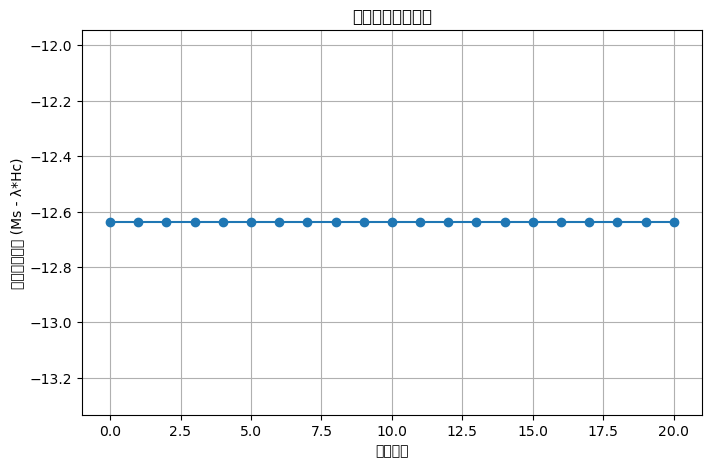

In [137]:
# 可视化迭代过程中最佳复合指标的变化
plt.figure(figsize=(8, 5))
plt.plot(range(iterations + 1), iteration_best, marker='o', linestyle='-')
plt.xlabel('迭代次数')
plt.ylabel('最佳复合指标 (Ms - λ*Hc)')
plt.title('复合指标优化进程')
plt.grid(True)
plt.savefig('优化进程.png')
plt.show()